## This notebook will help you train a vanilla Point-Cloud AE with the basic architecture we used in our paper.
    (it assumes latent_3d_points is in the PYTHONPATH and the structural losses have been compiled)

In [1]:
import os.path as osp

import sys
sys.path.append('/home/jcollins')

from latent_3d_points.src.ae_templates import mlp_architecture_ala_iclr_18, default_train_params, \
                                              jack_1_template
from latent_3d_points.src.autoencoder import Configuration as Conf
from latent_3d_points.src.point_net_ae import PointNetAutoEncoder

from latent_3d_points.src.in_out import snc_category_to_synth_id, create_dir, PointCloudDataSet, \
                                        load_all_point_clouds_under_folder

from latent_3d_points.src.tf_utils import reset_tf_graph
from latent_3d_points.src.general_utils import plot_3d_point_cloud
import gc

import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

%load_ext autoreload
%autoreload 2
%matplotlib inline

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Define Basic Parameters

In [2]:
top_out_dir = '../data/'          # Use to save Neural-Net check-points etc.
top_in_dir = '../data/shape_net_core_uniform_samples_2048/' # Top-dir of where point-clouds are stored.

experiment_name = 'single_class_ae_bneck-1'
n_pc_points = 1000                # Number of points per model.
bneck_size = 1                  # Bottleneck-AE size
ae_loss = 'emd'                   # Loss to optimize: 'emd' or 'chamfer'

Load Point-Clouds

In [3]:
import pandas as pd
numjets = 200000
numvalid = 10000
outstore = pd.HDFStore("/data1/users/jcollins/Heidelberg_sample/train_points_2.h5")
rawdata = outstore.select("points",stop=numjets).values
rawdata = rawdata.reshape(numjets,1000,2)
validdata = outstore.select("points",start=numjets,stop=numjets+numvalid).values
validdata = validdata.reshape(numvalid,1000,2)
all_pc_data = PointCloudDataSet(rawdata,copy=False)
valid_pc_data = PointCloudDataSet(validdata,copy=False)
gc.collect()

48

Load default training parameters (some of which are listed beloq). For more details please print the configuration object.

    'batch_size': 50   
    
    'denoising': False     (# by default AE is not denoising)

    'learning_rate': 0.0005

    'z_rotate': False      (# randomly rotate models of each batch)
    
    'loss_display_step': 1 (# display loss at end of these many epochs)
    'saver_step': 10       (# over how many epochs to save neural-network)

In [4]:
train_params = default_train_params()

In [5]:
encoder, decoder, enc_args, dec_args = jack_1_template(n_pc_points, bneck_size)
train_dir = create_dir(osp.join(top_out_dir, experiment_name))

In [6]:
conf = Conf(n_input = [n_pc_points, 2],
            loss = ae_loss,
            training_epochs = train_params['training_epochs'],
            batch_size = train_params['batch_size'],
            denoising = train_params['denoising'],
            learning_rate = train_params['learning_rate'],
            train_dir = train_dir,
            loss_display_step = train_params['loss_display_step'],
            saver_step = train_params['saver_step'],
            z_rotate = train_params['z_rotate'],
            encoder = encoder,
            decoder = decoder,
            encoder_args = enc_args,
            decoder_args = dec_args
           )
conf.experiment_name = experiment_name
conf.held_out_step = 1   # How often to evaluate/print out loss on 
                         # held_out data (if they are provided in ae.train() ).
conf.save(osp.join(train_dir, 'configuration'))

Build AE Model.

In [7]:
reset_tf_graph()
ae = PointNetAutoEncoder(conf.experiment_name, conf)

Building Encoder
Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.
encoder_conv_layer_0 conv params =  384 bnorm params =  256
Tensor("single_class_ae_bneck-1_2/Relu:0", shape=(?, 1000, 128), dtype=float32)
output size: 128000 

encoder_conv_layer_1 conv params =  16512 bnorm params =  256
Tensor("single_class_ae_bneck-1_2/Relu_1:0", shape=(?, 1000, 128), dtype=float32)
output size: 128000 

Symmetry Layer:
Tensor("single_class_ae_bneck-1_2/Sum:0", shape=(?, 128), dtype=float32) 

encoder_dense_layer_0 FC params =  16512 bnorm params =  256
Tensor("single_class_ae_bneck-1_2/Relu_2:0", shape=(?, 128), dtype=float32)
output size: 128 

encoder_dense_layer_1 FC params =  16512 bnorm params =  256
Tensor("single_class_ae_bneck-1_2/Relu_3:0", shape=(?, 128), dtype=float32)
output size: 128 

encoder_dense_layer_2 FC params =  129 bnorm params =  2
Tensor("single_class_ae_bneck-1_2/Relu_4:0", shape=(?, 1), dtype=floa

Train the AE (save output to train_stats.txt) 

In [8]:
buf_size = 1 # Make 'training_stats' file to flush each output line regarding training.
fout = open(osp.join(conf.train_dir, 'train_stats_2.txt'), 'a', buf_size)
train_stats = ae.train(all_pc_data, conf, log_file=fout,held_out_data=valid_pc_data)
fout.close()

('Epoch:', '0001', 'training time (minutes)=', '5.2394', 'loss=', '0.170943579')
INFO:tensorflow:../data/single_class_ae_bneck-1/models.ckpt-1 is not in all_model_checkpoint_paths. Manually adding it.
('Held Out Data :', 'forward time (minutes)=', '0.1674', 'loss=', '0.163609672')


KeyboardInterrupt: 

If you ran the above lines, you can reload a saved model like this:

In [10]:
load_pre_trained_ae = True
restore_epoch = 30
if load_pre_trained_ae:
    conf = Conf.load(train_dir + '/configuration')
    reset_tf_graph()
    ae = PointNetAutoEncoder(conf.experiment_name, conf)
    ae.restore_model(conf.train_dir, epoch=restore_epoch)

Building Encoder
Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.
encoder_conv_layer_0 conv params =  384 bnorm params =  256
Tensor("single_class_ae_2/Relu:0", shape=(?, 1000, 128), dtype=float32)
output size: 128000 

encoder_conv_layer_1 conv params =  16512 bnorm params =  256
Tensor("single_class_ae_2/Relu_1:0", shape=(?, 1000, 128), dtype=float32)
output size: 128000 

Symmetry Layer:
Tensor("single_class_ae_2/Sum:0", shape=(?, 128), dtype=float32) 

encoder_dense_layer_0 FC params =  16512 bnorm params =  256
Tensor("single_class_ae_2/Relu_2:0", shape=(?, 128), dtype=float32)
output size: 128 

encoder_dense_layer_1 FC params =  16512 bnorm params =  256
Tensor("single_class_ae_2/Relu_3:0", shape=(?, 128), dtype=float32)
output size: 128 

encoder_dense_layer_2 FC params =  2580 bnorm params =  40
Tensor("single_class_ae_2/Relu_4:0", shape=(?, 20), dtype=float32)
output size: 20 

Building Decoder
decod

Get a batch of reconstuctions and their latent-codes.

Use any plotting mechanism such as matplotlib to visualize the results.

In [11]:
from matplotlib.colors import LogNorm
import numpy as np
import matplotlib.pyplot as plt

In [30]:
numload = 50
feed_pc, feed_model_names, _ = valid_pc_data.next_batch(numload )
reconstructions = ae.reconstruct(feed_pc)[0]
latent_codes = ae.transform(feed_pc)


In [41]:
reconstructions[0]

array([[ 0.01786133,  0.07966199],
       [ 0.00784282,  0.04968918],
       [-0.08340554, -0.15144625],
       ...,
       [ 0.00708917, -0.00727632],
       [ 0.00694195, -0.03008229],
       [ 0.00558822,  0.04566509]], dtype=float32)

In [60]:

npoints=1000
M = np.sqrt(ot.dist(points1[0],points2[0]))

In [63]:
import ot
ot.emd2(np.ones(1000),np.ones(1000),M)

51.190226237026486

In [ ]:
points1 = np.random.rand(nclouds,npoints,ndim)
points2 = points1 + 2*0.1*(np.random.rand(nclouds,npoints,ndim)-0.5)
#points1[:,:,2] = np.zeros(npoints)
#points2[:,:,2] = np.zeros(npoints)
M = np.array([np.sqrt(ot.dist(points1[i].reshape((npoints,ndim)),points2[i].reshape((npoints,ndim)))) for i in range(nclouds)])
M2 = np.array([ot.dist(points1[i],points2[i]) for i in range(nclouds)])

In [75]:
import time
from latent_3d_points.external.structural_losses import tf_approxmatch

nclouds = 1
npoints = 1000
ndim=2

points1 = reconstructions[:10]
points2 = feed_pc[:10]

start = time.time()

this = tf_approxmatch.approx_match(points1,points2)
init_op = tf.initialize_all_variables()


#run the graph
with tf.Session() as sess:
    sess.run(init_op) #execute init_op
    #print the random values that we sample
    transport = sess.run(this)
    #print transport

this_cost = tf_approxmatch.match_cost(points1,points2,transport)
init_op = tf.initialize_all_variables()

#run the graph
with tf.Session() as sess:
    sess.run(init_op) #execute init_op
    #print the random values that we sample
    cost = sess.run(this_cost)
    print cost
    
print time.time()-start

[ 58.18377   81.6858    97.5859    63.88533   63.98101   73.542366
  77.54348   76.7893   116.09449   72.19047 ]
4.09626317024


In [73]:
58./1000

0.058

In [78]:
start = time.time()
M = [np.sqrt(ot.dist(points1[i],points1[i+1])) for i in range(len(points1)-1)]

truecost = [ot.emd2(np.ones(1000),np.ones(1000),Mat) for Mat in M]
print time.time()-start

1.65835189819


In [70]:
print truecost

[51.190226237026486, 70.61418059926356, 81.52088198278226, 55.41022253464365, 58.26244392341716, 62.070170506169184, 67.71536697821631, 60.39265739536654, 113.75063251282751, 65.58223362731748]


In [71]:
print (np.array(cost) - np.array(truecost))/np.array(truecost)

[0.13661872 0.15679029 0.19706629 0.15295206 0.09815185 0.18482623
 0.14513859 0.27150058 0.02060523 0.10076257]


In [ ]:
nclouds = 10
npoints = 15
ndim=3

points1 = reconstructions[:1]
points2 = feed_pc[:1]
#points1[:,:,2] = np.zeros(npoints)
#points2[:,:,2] = np.zeros(npoints)
M = np.array([np.sqrt(ot.dist(points1[i].reshape((npoints,ndim)),points2[i].reshape((npoints,ndim)))) for i in range(nclouds)])

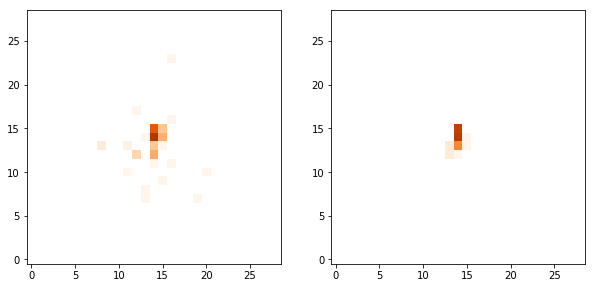

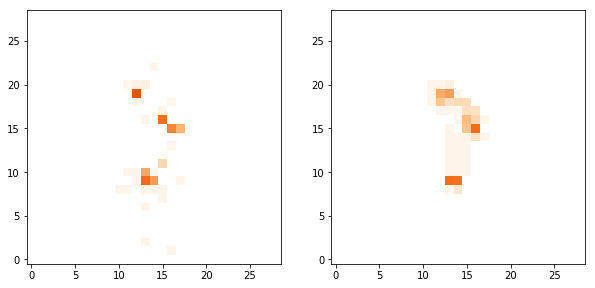

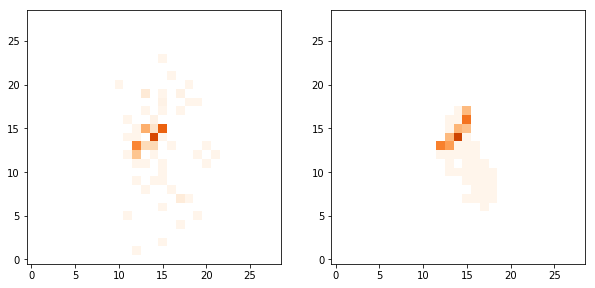

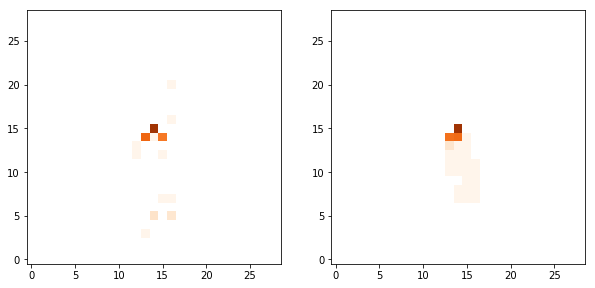

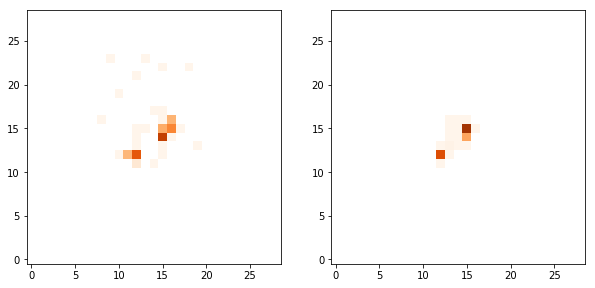

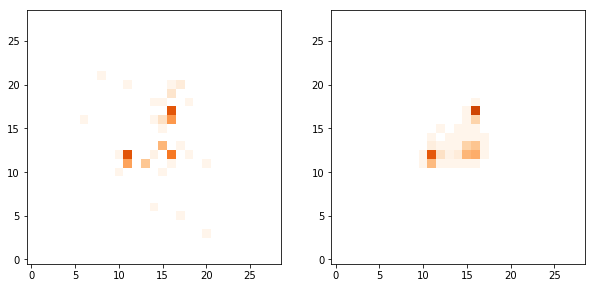

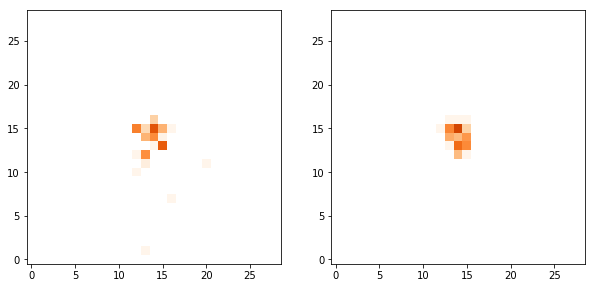

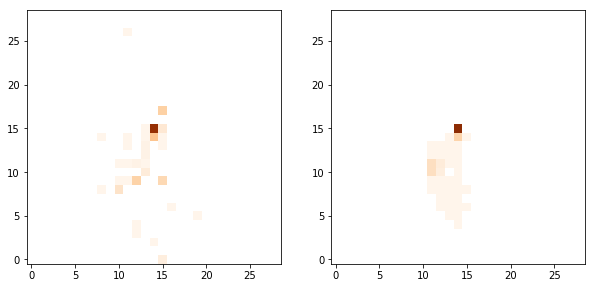

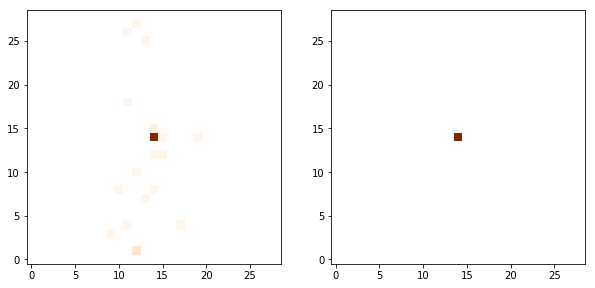

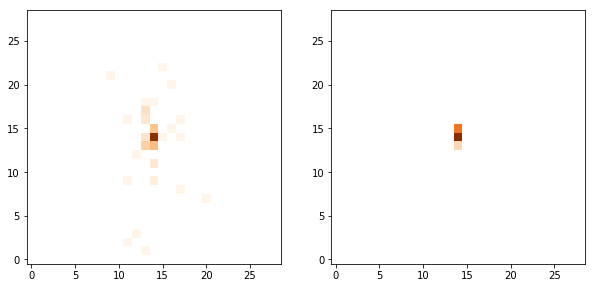

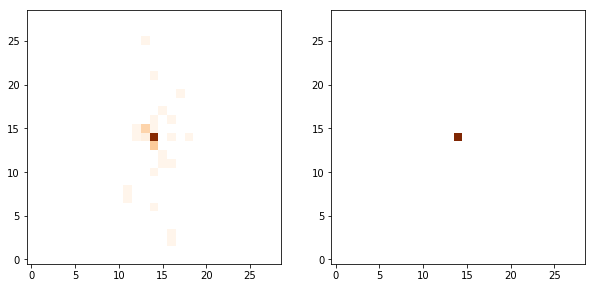

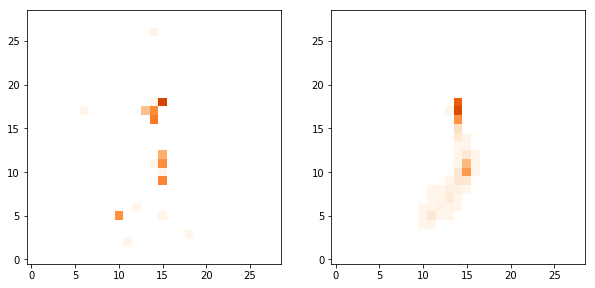

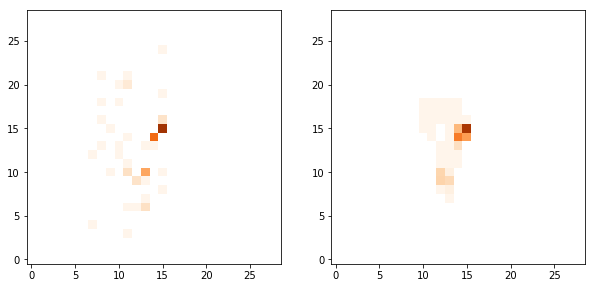

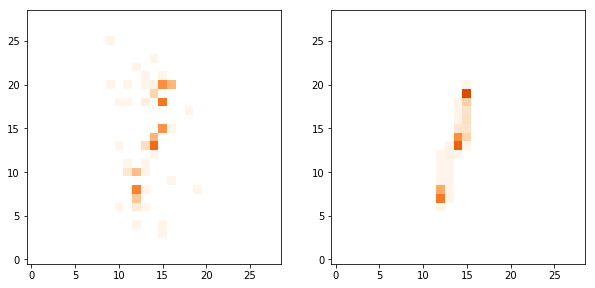

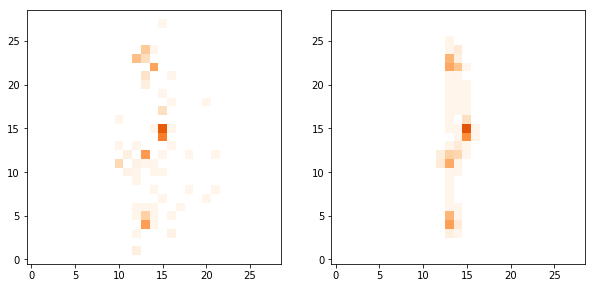

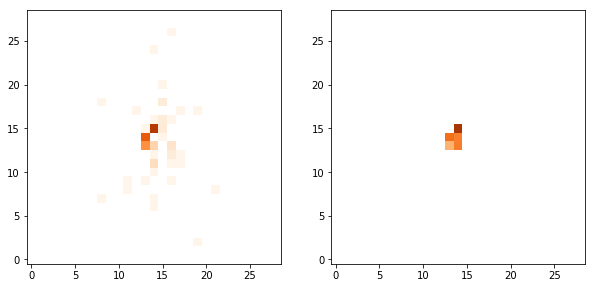

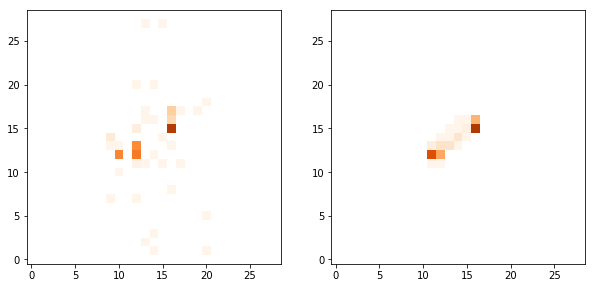

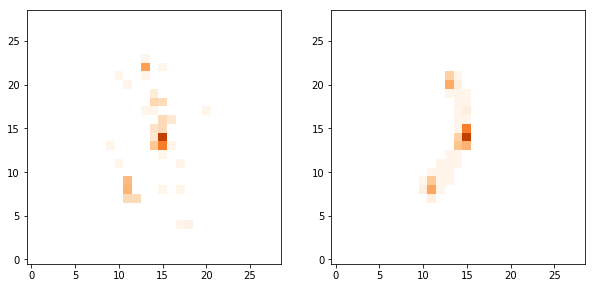

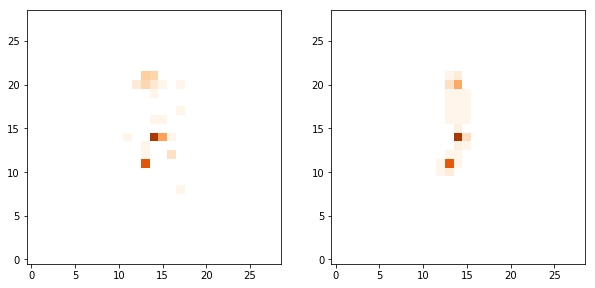

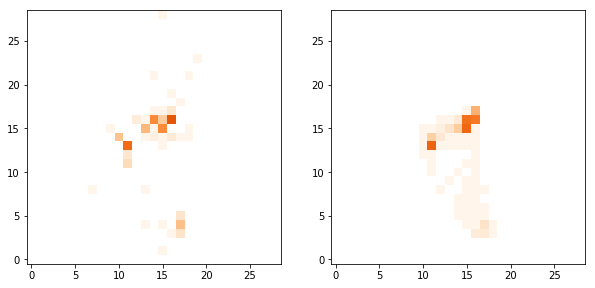

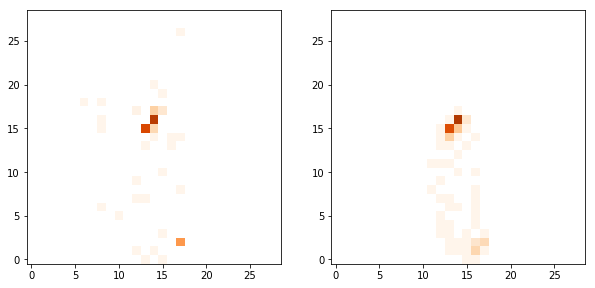

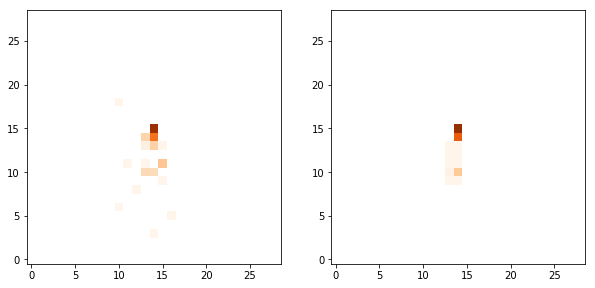

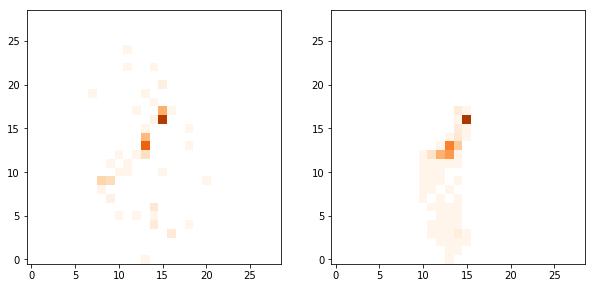

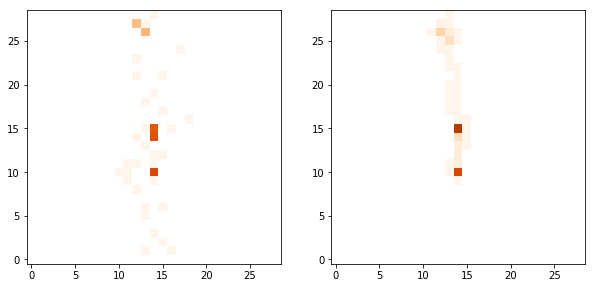

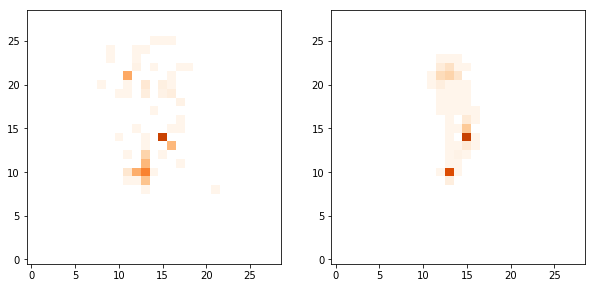

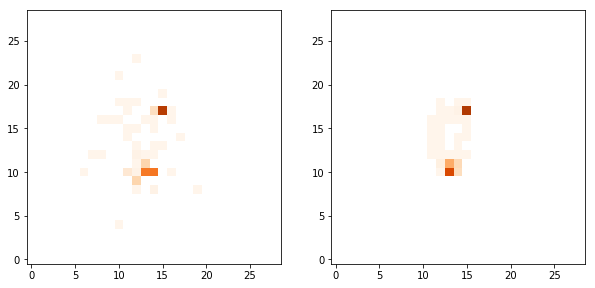

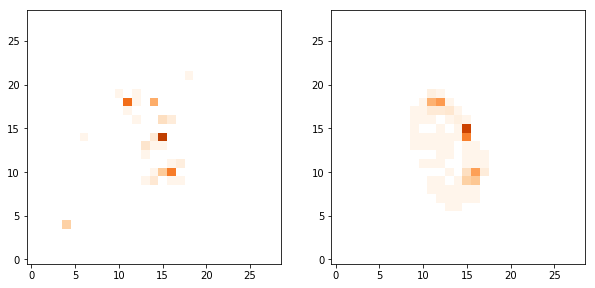

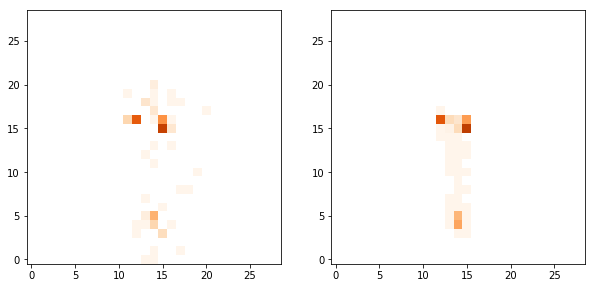

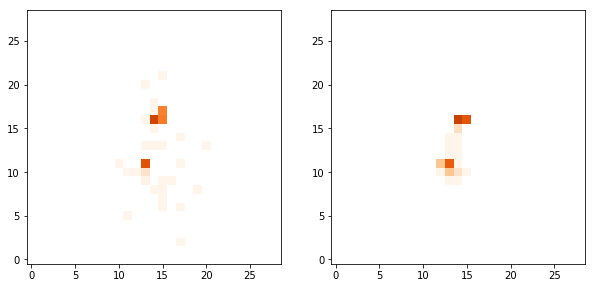

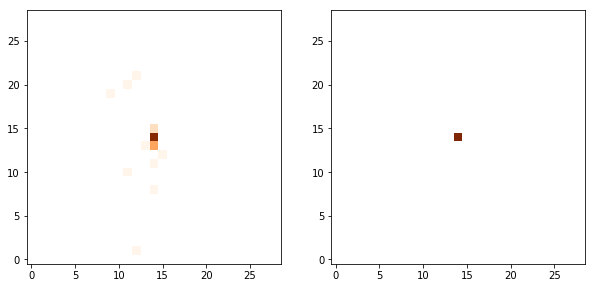

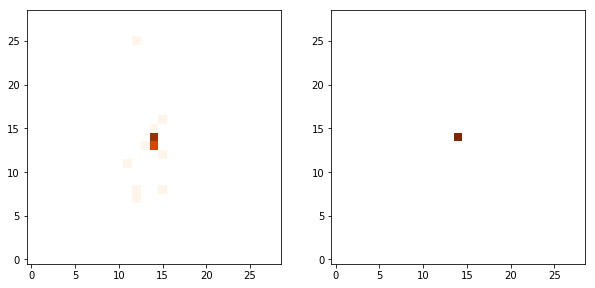

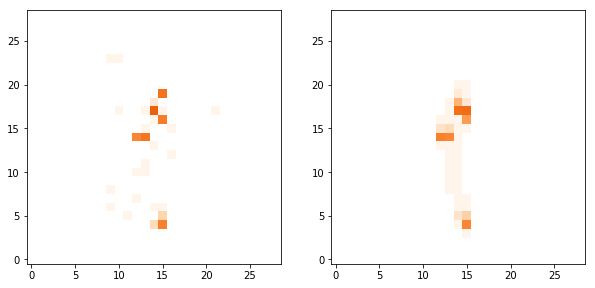

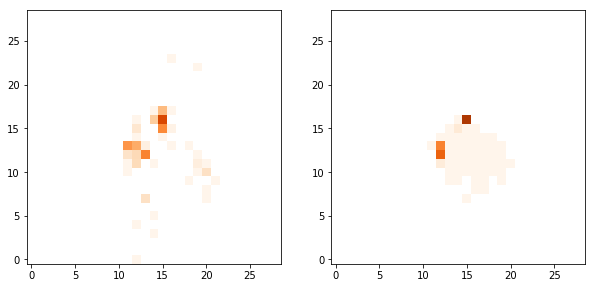

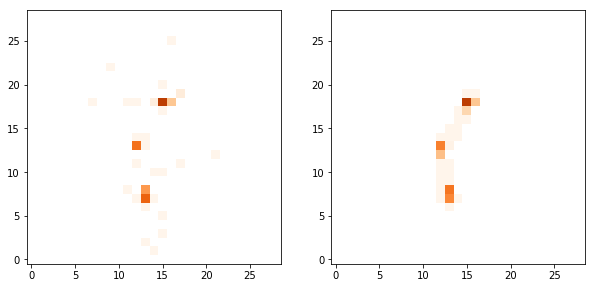

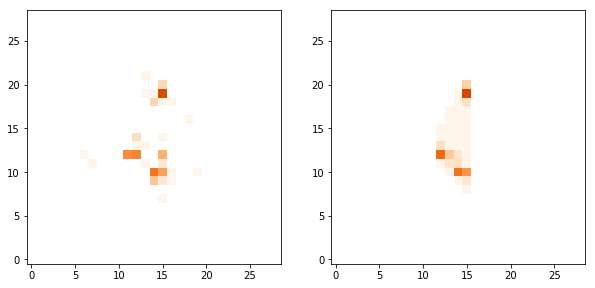

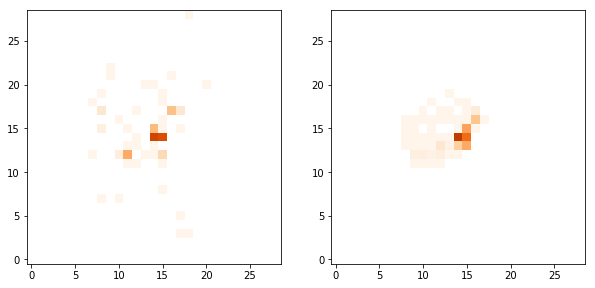

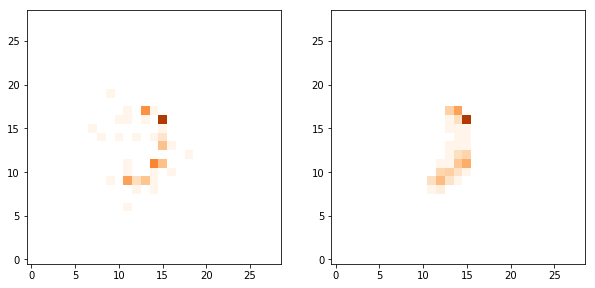

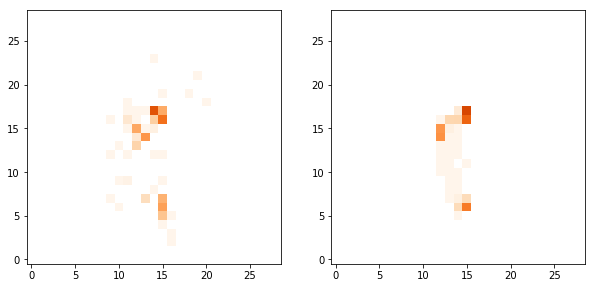

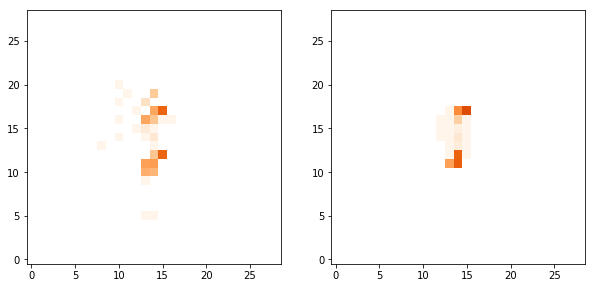

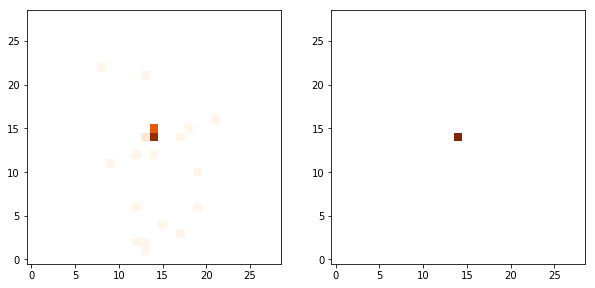

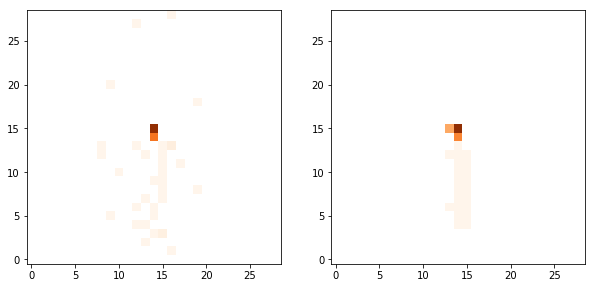

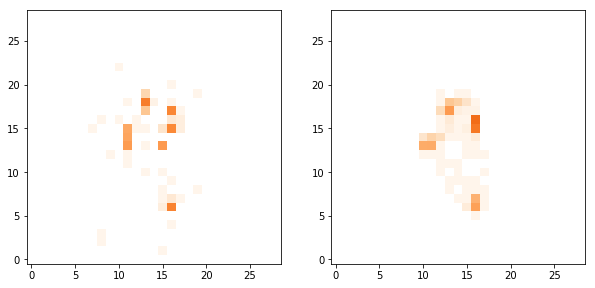

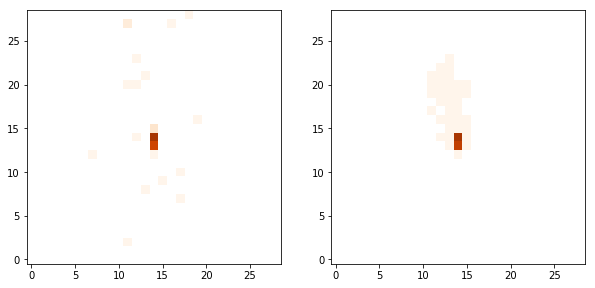

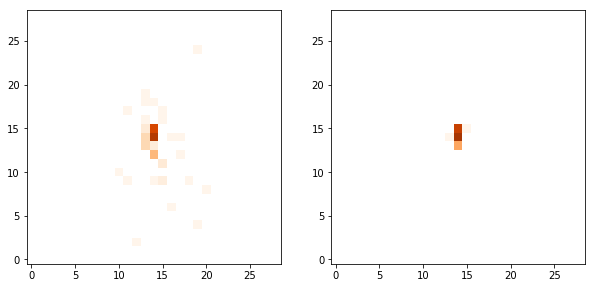

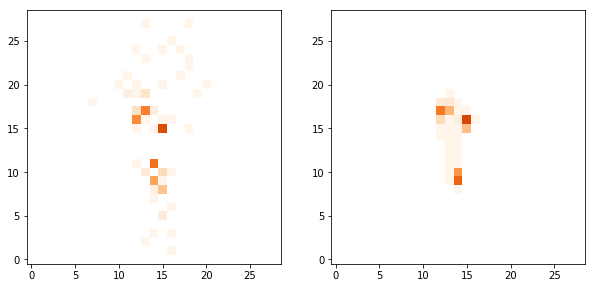

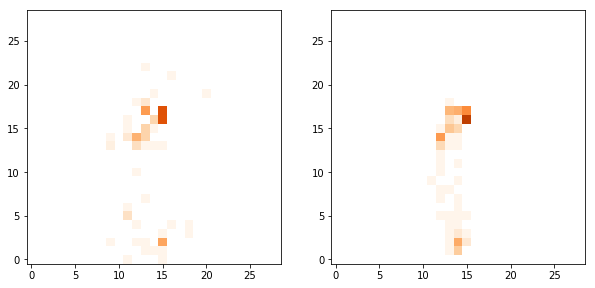

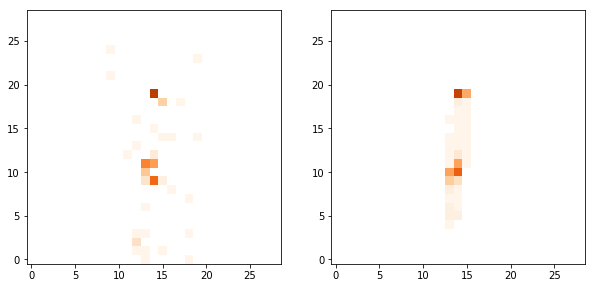

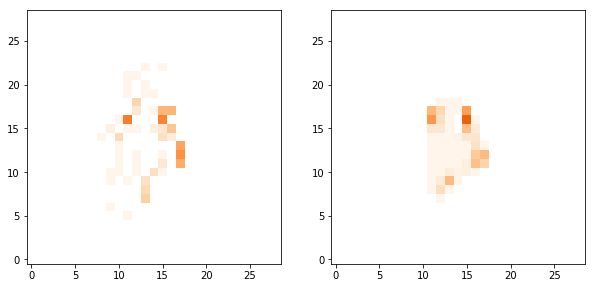

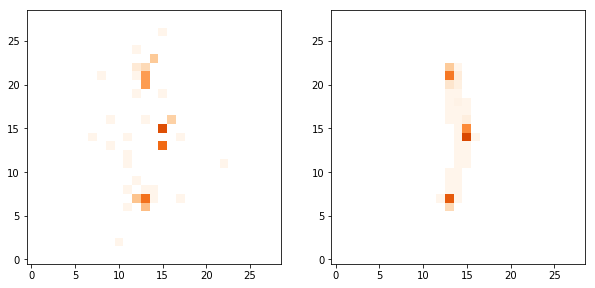

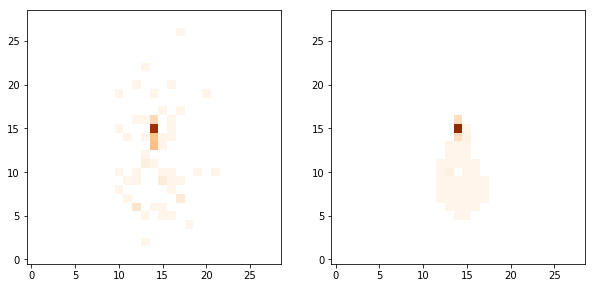

In [39]:
countcut=0.5
lim=1.5
bins=np.linspace(-lim, lim, 30)

for i in range(len(feed_pc)):
    fig, ax = plt.subplots(1, 2,figsize=[10,5])
    counts, bx, by = np.histogram2d(feed_pc[i][:,0],feed_pc[i][:,1],bins=bins)
    counts[counts < countcut] = 0
    ax[0].imshow(counts.T , norm=LogNorm(10, 1000), origin='lower',cmap='Oranges')
    #ax[0].hist2d(feed_pc[i][:,0],feed_pc[i][:,1],range=[[-lim,lim],[-lim,lim]],bins=bins, norm=LogNorm(0.5, 1000))
    counts, bx, by = np.histogram2d(reconstructions[i][:,0],reconstructions[i][:,1],bins=bins)
    counts[counts < countcut] = 0
    ax[1].imshow(counts.T, norm=LogNorm(10, 1000), origin='lower',cmap='Oranges')
    plt.show()

In [12]:
import pandas as pd
numtops = 10000

store = pd.HDFStore("/data1/users/jcollins/Heidelberg_sample/train_points_top.h5")
rawdata = store.select("points",stop=numtops).values
rawdata = rawdata.reshape(numtops,1000,2)

top_pc_data = PointCloudDataSet(rawdata)

In [13]:
numload = 50
feed_pc, feed_model_names, _ = top_pc_data.next_batch(numload )
reconstructions = ae.reconstruct(feed_pc)[0]

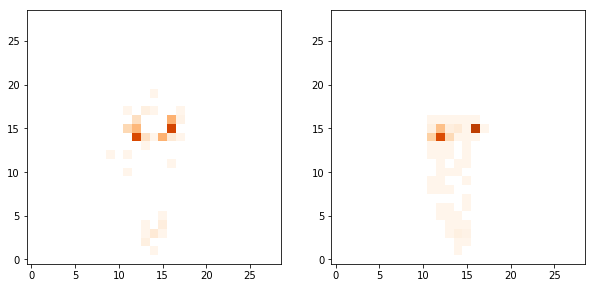

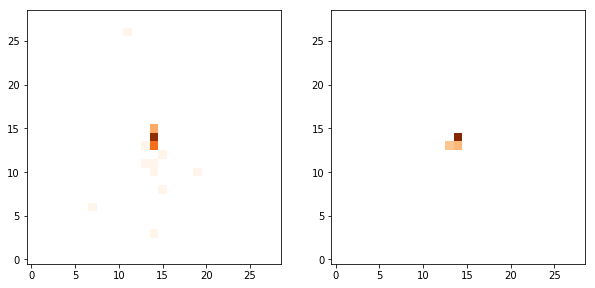

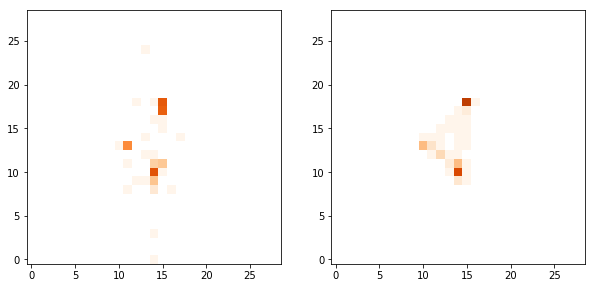

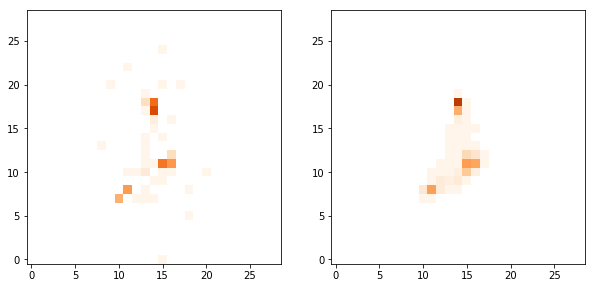

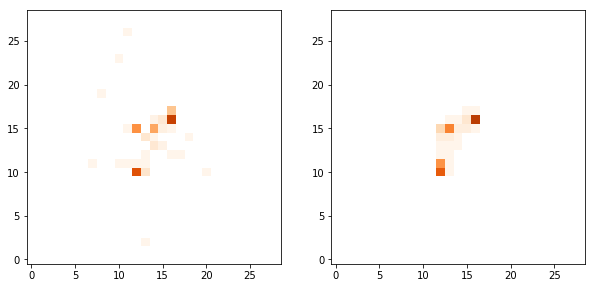

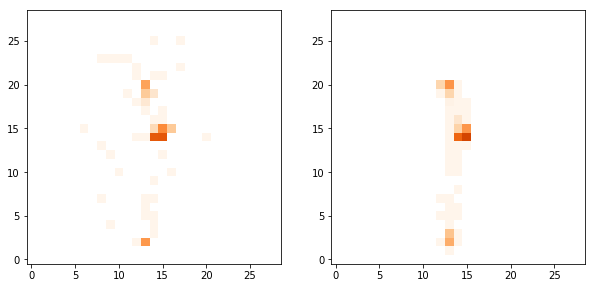

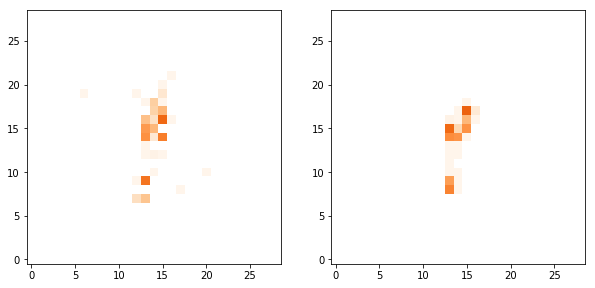

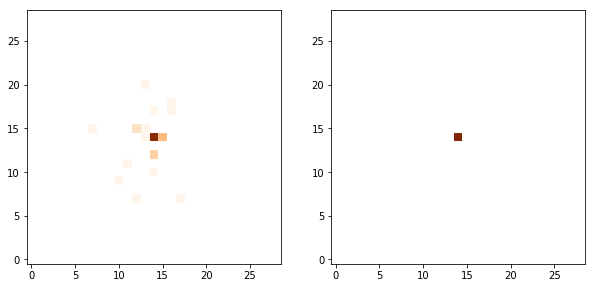

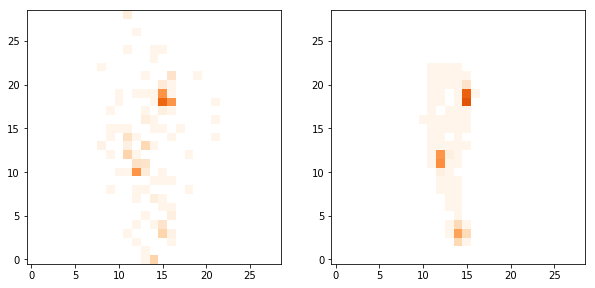

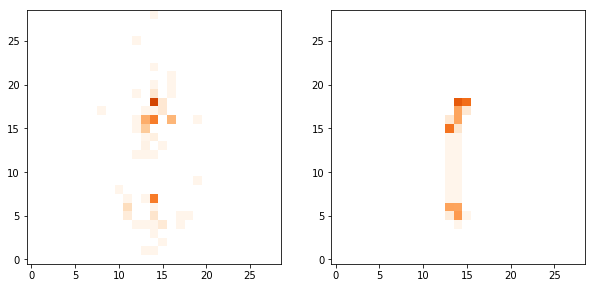

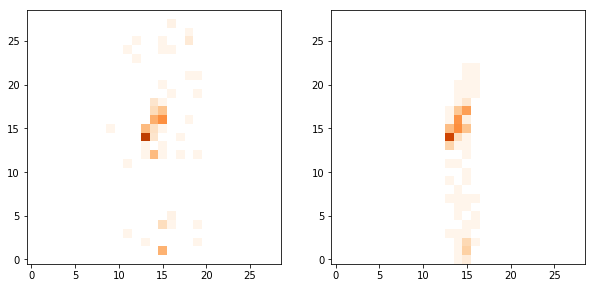

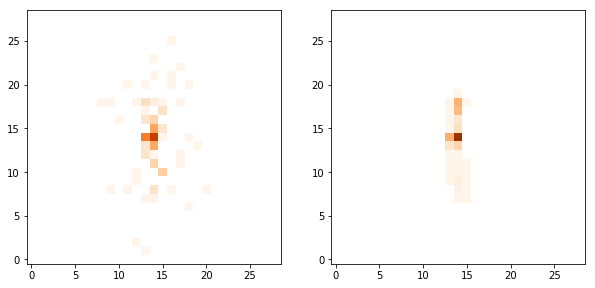

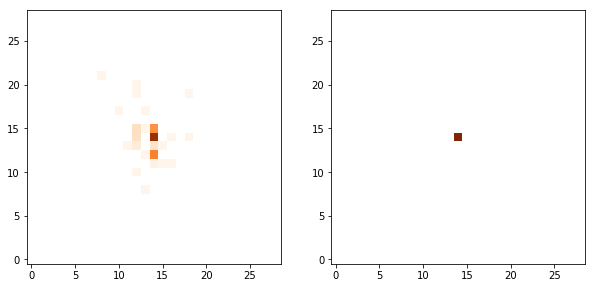

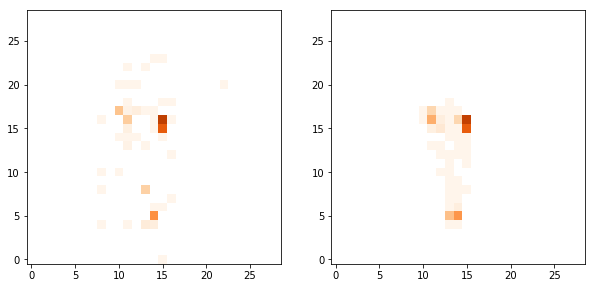

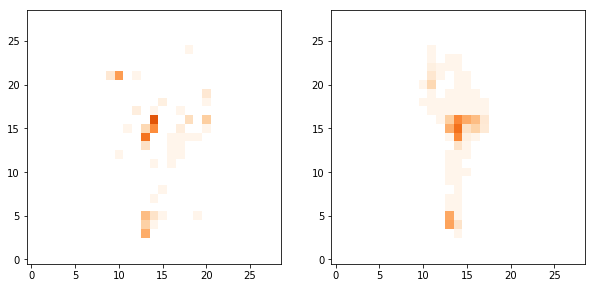

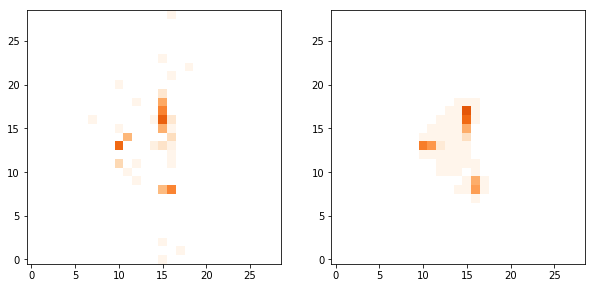

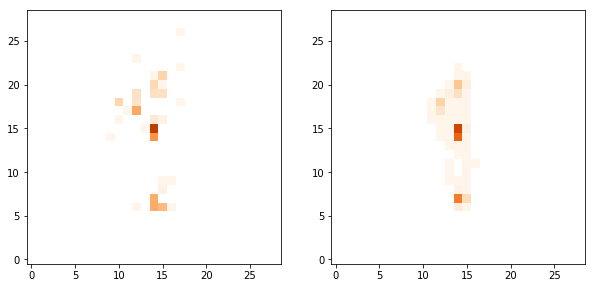

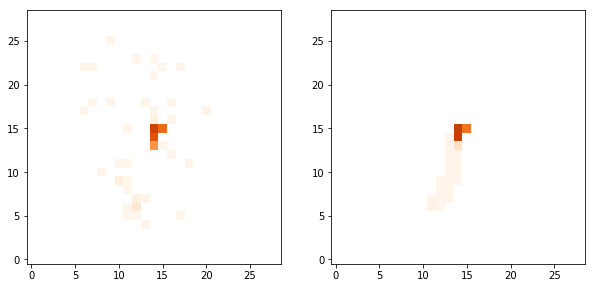

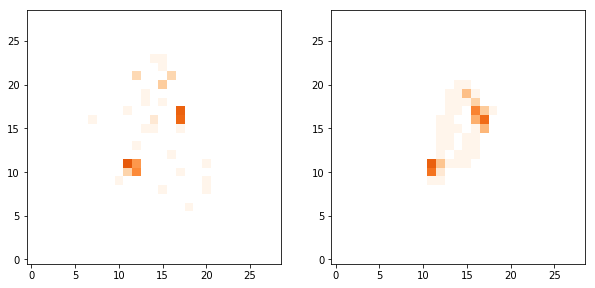

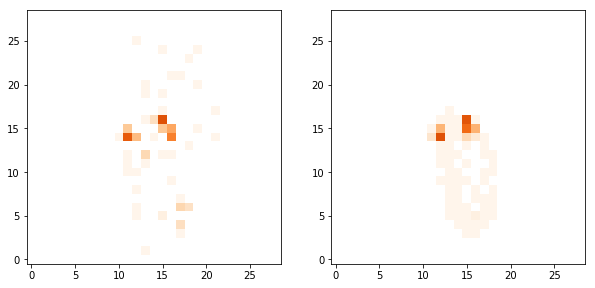

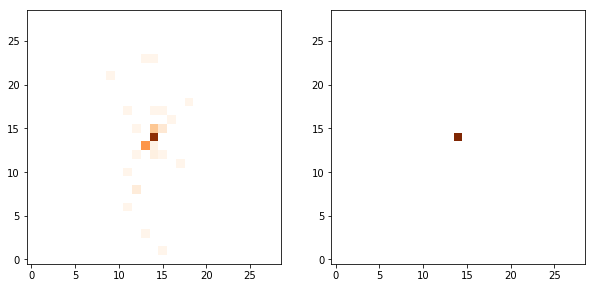

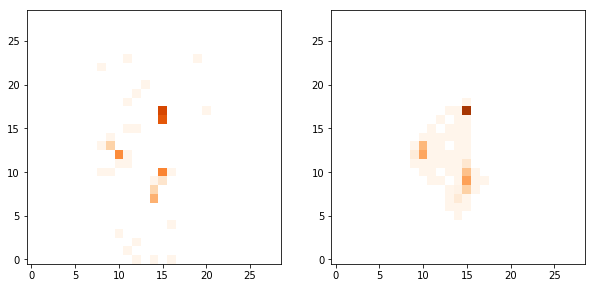

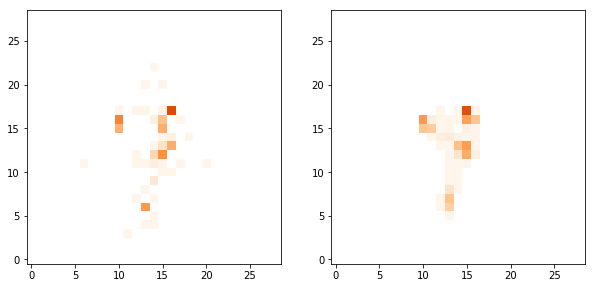

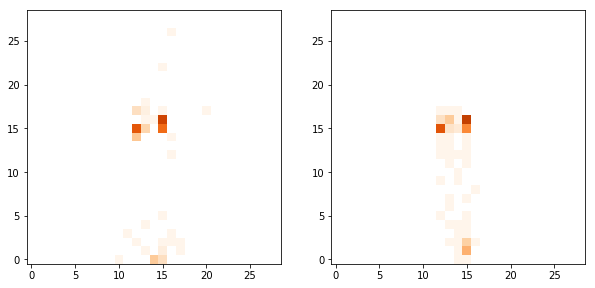

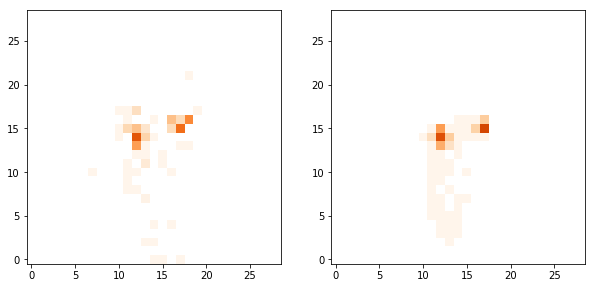

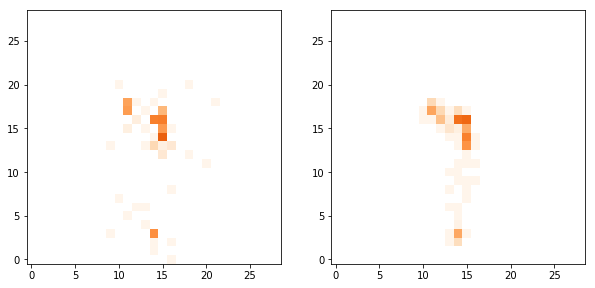

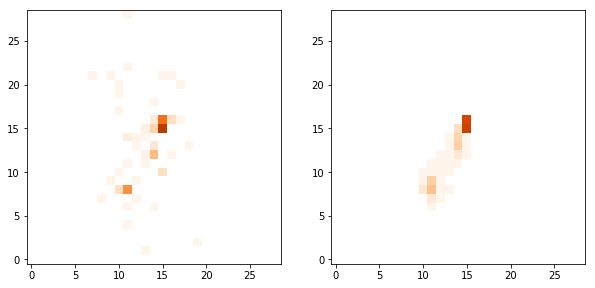

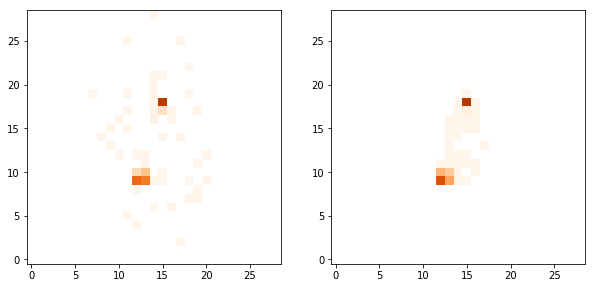

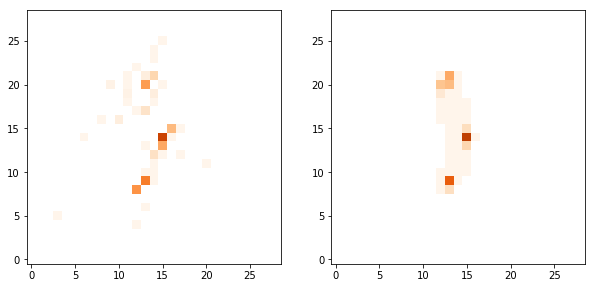

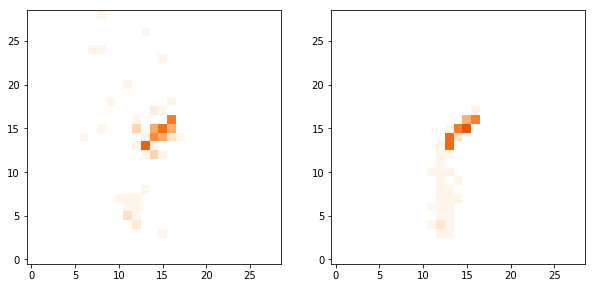

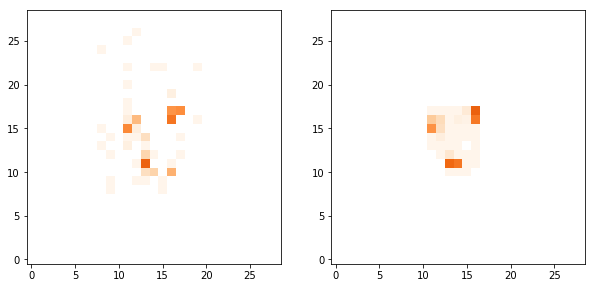

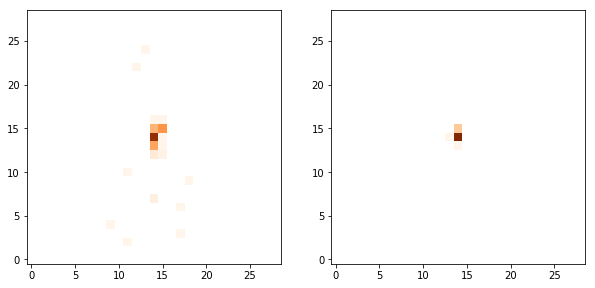

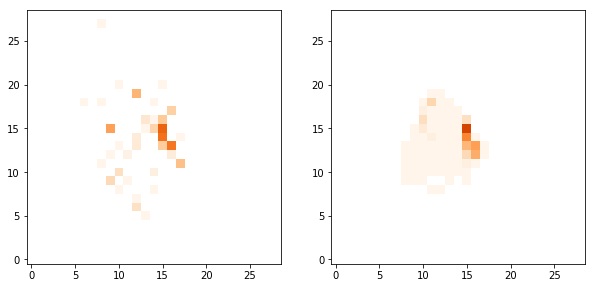

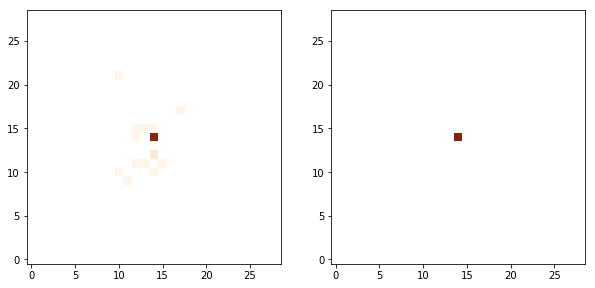

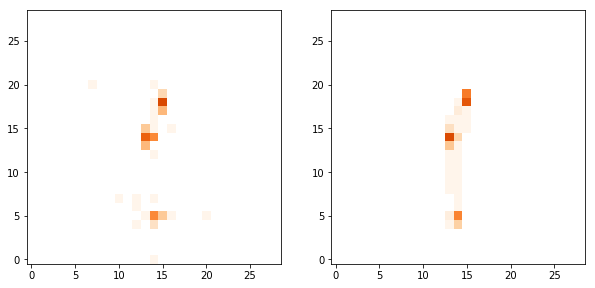

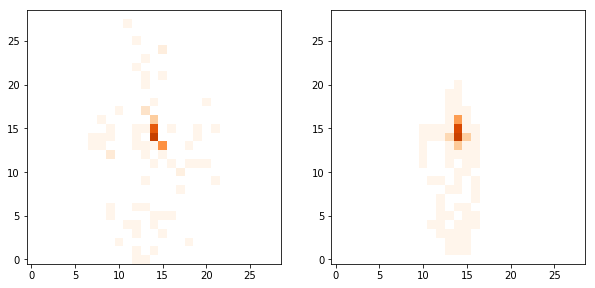

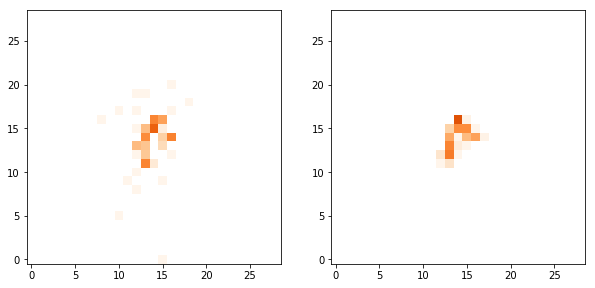

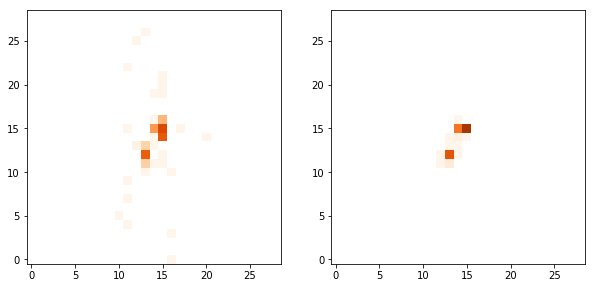

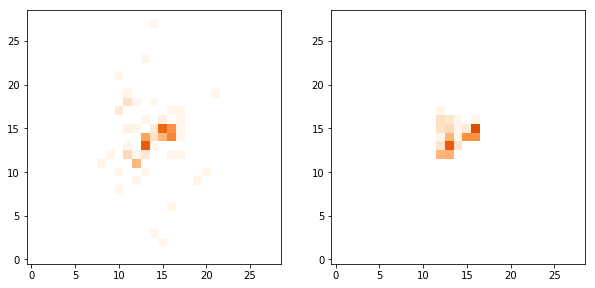

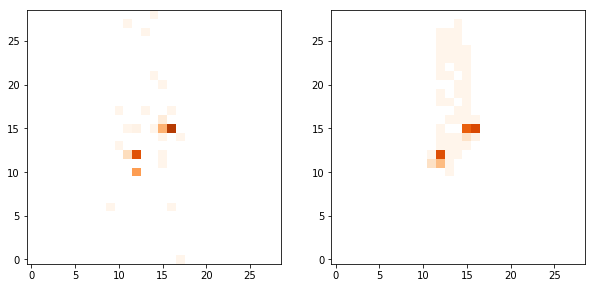

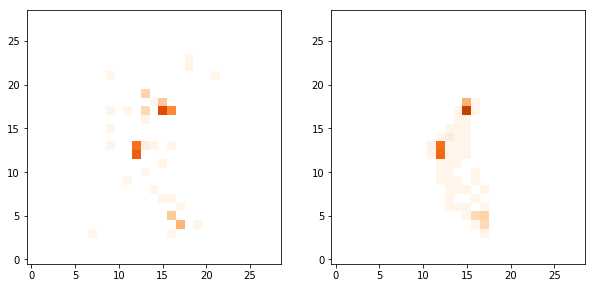

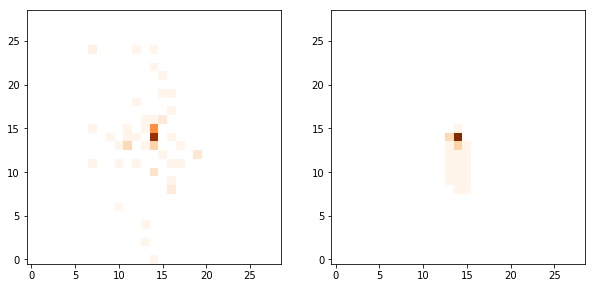

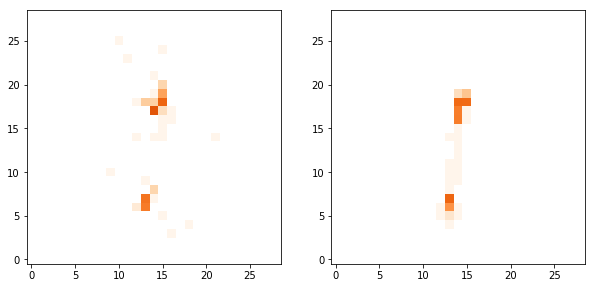

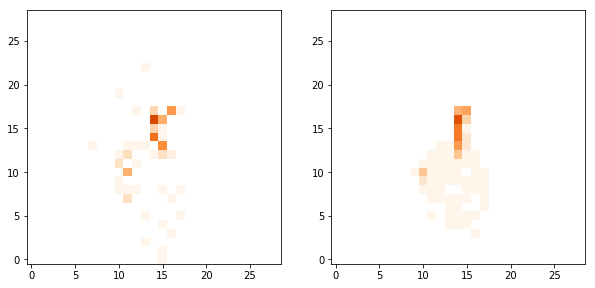

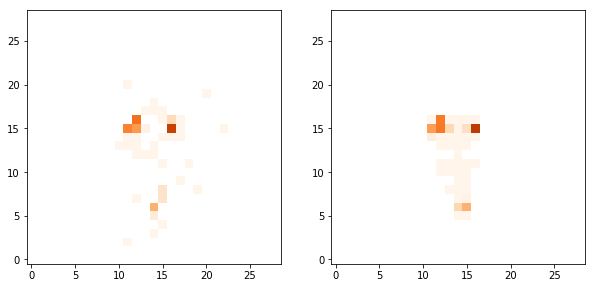

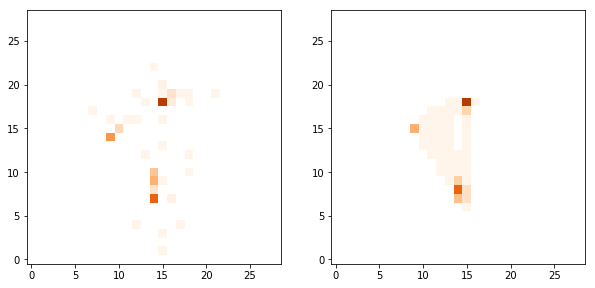

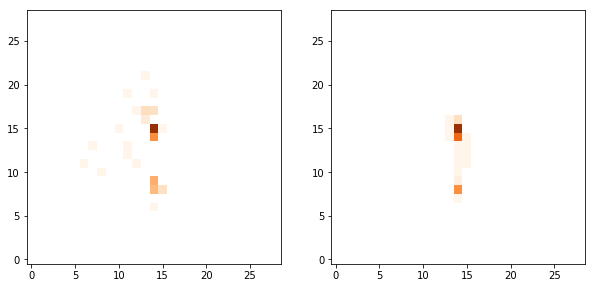

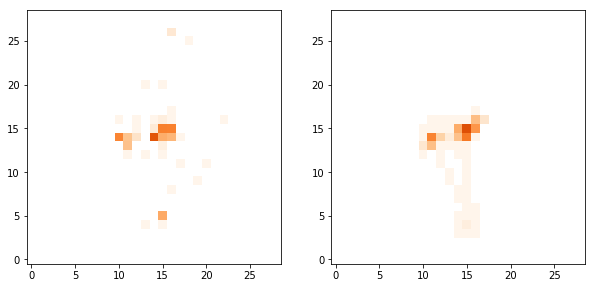

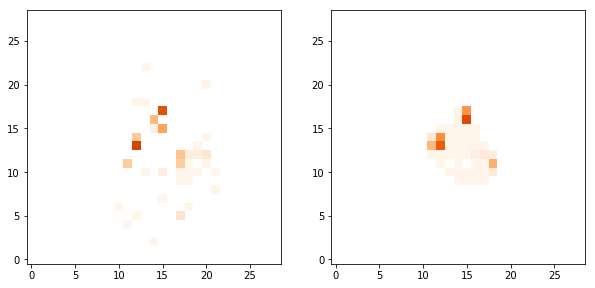

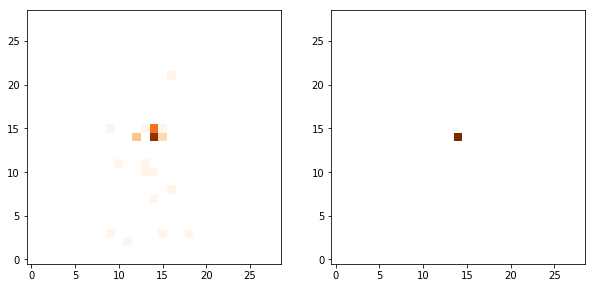

In [14]:
countcut=0.5
lim=1.5
bins=np.linspace(-lim, lim, 30)

for i in range(len(feed_pc)):
    fig, ax = plt.subplots(1, 2,figsize=[10,5])
    counts, bx, by = np.histogram2d(feed_pc[i][:,0],feed_pc[i][:,1],bins=bins)
    counts[counts < countcut] = 0
    ax[0].imshow(counts.T , norm=LogNorm(10, 1000), origin='lower',cmap='Oranges')
    #ax[0].hist2d(feed_pc[i][:,0],feed_pc[i][:,1],range=[[-lim,lim],[-lim,lim]],bins=bins, norm=LogNorm(0.5, 1000))
    counts, bx, by = np.histogram2d(reconstructions[i][:,0],reconstructions[i][:,1],bins=bins)
    counts[counts < countcut] = 0
    ax[1].imshow(counts.T, norm=LogNorm(10, 1000), origin='lower',cmap='Oranges')
    plt.show()

In [17]:
import time
import ot
from latent_3d_points.external.structural_losses import tf_approxmatch

nclouds = 1
npoints = 1000
ndim=2

points1 = reconstructions[:100]
points2 = feed_pc[:100]

start = time.time()

this = tf_approxmatch.approx_match(points1,points2)
init_op = tf.initialize_all_variables()


#run the graph
with tf.Session() as sess:
    sess.run(init_op) #execute init_op
    #print the random values that we sample
    transport = sess.run(this)
    #print transport

this_cost = tf_approxmatch.match_cost(points1,points2,transport)
init_op = tf.initialize_all_variables()

#run the graph
with tf.Session() as sess:
    sess.run(init_op) #execute init_op
    #print the random values that we sample
    cost = np.array(sess.run(this_cost))
    print cost
    
print time.time()-start

start = time.time()
M = [np.sqrt(ot.dist(points1[i],points2[i])) for i in range(len(points1))]

truecost = np.array([ot.emd2(np.ones(1000),np.ones(1000),Mat) for Mat in M])
print truecost
print time.time()-start

print (cost - truecost)/truecost

[ 53.406593  34.03489   59.73945   66.158264  53.420918  79.9616
  86.84847   39.692226 156.09245  101.356125 106.99286  100.451065
  70.34574   62.29555  122.35143   88.86858   67.99644   76.37024
  84.37109   93.457306  66.095474  93.4153    79.04248   58.091164
  99.875534  67.234825  78.94486   72.354225  71.340096  89.15998
  95.516335  57.31603  108.99463   24.371166  49.63926  119.86563
  77.71489   65.82697  105.69177   73.86088   62.853054 104.73592
  74.7922   105.80368   64.9297    80.99471   37.74513   96.229225
  94.652985  54.562977]
18.8843090534
[ 46.04185501  31.25577202  52.98283554  56.96950004  45.85207452
  65.79024043  69.92851026  38.14159601 130.56427641  87.5069085
  88.87222255  83.48156546  67.8417792   53.74904545 105.91678524
  74.74135142  55.70980017  65.98393249  72.06765964  77.89964553
  64.37710023  79.57467253  66.41809647  47.99037091  80.54316368
  53.27405351  63.21508367  62.58679039  62.6132607   75.94195879
  80.32700007  53.80063544  88.811083